## Singapore Rainfall data for the location (1.30◦N,103.68◦E), collected in year 2010 from ground-based weather station with high resolution.
---

Exploratory analysis - Initial Plotting and Data Parsing.

In [1]:
%matplotlib inline
from glob import glob # For selecting multiple filenames
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import xarray as xr
import seaborn as sns # for density plots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Used for DTW
from scipy.spatial.distance import cdist
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from datetime import datetime
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (16,5) # For Increasing Size of graph

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Importing
---

* For **PRAT - PRivate and Agile Temporally data**, which is the ground based station with high resolution

In [3]:
# Dataframe for PRAT--> PRivate and Agile Temporally data
prat_rainfall_df = pd.read_csv("data/imagerdata.csv", header=None, names=["day", "hour", "minute", "rainfall_rate"])

* For **CHIRPS** - Satellite based public data

In [4]:
chirps_dataset = xr.open_dataset('data/chirps-2010.nc') # open the dataset using xarray

* From **Global Precipitation Measurement (GPM)**

In [5]:
gpm_dataset = xr.open_dataset('data/singaporeIMERG.nc')

* From **Ground based Gauge Station by Meteorological Service Singapore (MSS)**

In [6]:
# Import using glob
filenames = glob("data/daily_*.csv")
gauge_station_df = pd.concat([pd.read_csv(filename, encoding= 'unicode_escape', usecols = ['Year', 'Month', 'Day', 'Daily Rainfall Total (mm)']) 
                              for filename in filenames], axis=0)

gauge_station_df.head()

,Year,Month,Day,Daily Rainfall Total (mm)
0,2010,7,1,104.2
1,2010,7,2,18.4
2,2010,7,3,34.8
3,2010,7,4,0.0
4,2010,7,5,0.0


# Parsing the Datasets

* Gauge Station

Parse Year, Month and day. Convert to datetime. Set index to timestamp. Drop Year, Month and Day columns. Rename the column

In [8]:
# Semicolon is used to separate month and day, otherwise datetime is wrongly converted
gauge_station_df['timestamp'] = pd.to_datetime(gauge_station_df['Year'].astype(str) + 
                                               gauge_station_df['Month'].astype(str) + ":"+ 
                                               gauge_station_df['Day'].astype(str), format="%Y%m:%d")

gauge_station_df.set_index('timestamp', inplace=True)
gauge_station_df.drop(['Year', 'Month', 'Day'], inplace=True, axis=1)
gauge_station_df.sort_index(axis=0)
gauge_station_df.rename(columns={'Daily Rainfall Total (mm)':'rainfall_rate'}, inplace=True)

gauge_station_df.head()

,rainfall_rate
timestamp,
2010-07-01,104.2
2010-07-02,18.4
2010-07-03,34.8
2010-07-04,0.0
2010-07-05,0.0


* CHIRPS

In [29]:
# chirps_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-01-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()
# chirps_full_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

monsoon_chirps = chirps_dataset.sel(time=slice('2010-06-01','2010-09-30'), 
                                    longitude=103.67499, latitude=1.324997)

* GPM

The Dates are not of proper format. So, need to change it to suitable python datetime object

In [10]:
gpm_dataset['time'] = gpm_dataset.indexes['time'].to_datetimeindex()

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [11]:
# # gpm_sampled['precipitationCal'].plot()
# gpm_sampled.sel(time=slice('2010-06-01T00:0','2010-09-30T00:0'))['precipitationCal'].plot()

gpm_sampled = gpm_dataset.sel(lon=103.68, lat=1.30, method='nearest').resample(time='1D').sum()
gpm_sampled

<xarray.Dataset>
Dimensions:           (time: 365)
Coordinates:
  * time              (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
    lon               float32 103.65
    lat               float32 1.25
Data variables:
    precipitationCal  (time) float32 5.6014466 0.62149346 ... 0.92519027

* **PRAT**

In [12]:
# append the timedelta in hours and minutes to get the full timestamp
# Using day number to create the date

prat_rainfall_df['date']=pd.to_datetime(prat_rainfall_df['day'], unit='D', origin=pd.Timestamp('2009-12-31')) 

prat_rainfall_df['timestamp'] = prat_rainfall_df['date'] + pd.to_timedelta(prat_rainfall_df['hour'].astype('str') + 
                                                                               ':' + prat_rainfall_df['minute'].astype('str') + ':00') 
prat_rainfall_df.set_index('timestamp', inplace=True)

In [14]:
prat_sampled_df = pd.DataFrame()
prat_rainfall_df['rainfall_rate'] = prat_rainfall_df['rainfall_rate']/60.0 # mm / 60

# Groupby MONTH and then taking the total daily sum
prat_sampled_df = prat_rainfall_df.resample('D').sum() 

prat_sampled_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True) # Dropped the day, hour, minute columns
prat_sampled_df.head() # PRAT Data after resampling

,rainfall_rate
timestamp,
2010-01-01,18.0
2010-01-02,0.2
2010-01-03,0.2
2010-01-04,13.2
2010-01-05,0.0


In [15]:
gpm_dataset

<xarray.Dataset>
Dimensions:           (lat: 4, lon: 5, time: 17520)
Coordinates:
  * lat               (lat) float32 1.15 1.25 1.35 1.45
  * lon               (lon) float32 103.65 103.75 103.85 103.95 104.05
  * time              (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:30:00
Data variables:
    precipitationCal  (time, lon, lat) float32 ...
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  Grid_time
    history:                         2020-04-10 15:17:54 GMT Hyrax-1.15.1 htt...

# Monsoon Rainfall
According to [this](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/weather-and-climate-in-singapore),
There is no clear-cut wet or dry season and rain is experienced every single month, usually in the afternoons and early evenings. However, there are two main monsoon seasons in Singapore: **Northeast Monsoon Season (December-March) and the Southwest Monsoon Season (June-September)**.

* Extract Monsoon Data

In [42]:
JUNE = 6
SEPT = 9
monsoon_prat = prat_sampled_df[(prat_sampled_df.index.month >= JUNE) & (prat_sampled_df.index.month <= SEPT)]
monsoon_gauge = gauge_station_df[(gauge_station_df.index.month >= JUNE) & (gauge_station_df.index.month <= SEPT)]
monsoon_gauge = monsoon_gauge.sort_index(axis=0)
monsoon_gpm = gpm_sampled.sel(time=slice('2010-06-01','2010-09-30'))

* Plot the data

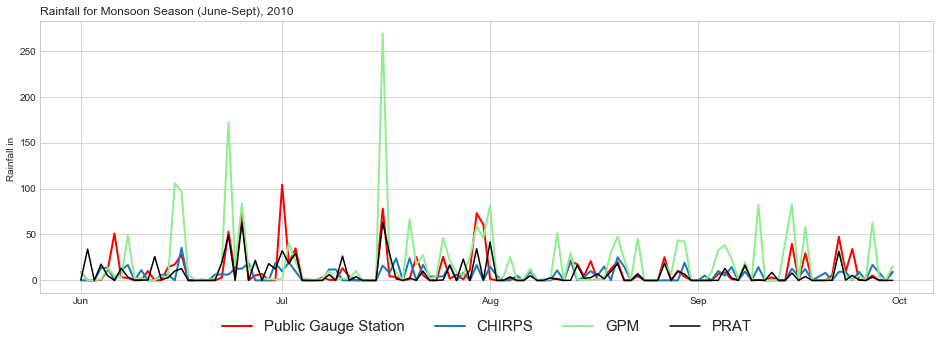

In [58]:
plt.plot(monsoon_gauge['rainfall_rate'], linewidth=2, label='Public Gauge Station', c='red')
plt.plot(monsoon_chirps['time'], monsoon_chirps['precip'], label='CHIRPS', linewidth=2)
plt.plot(monsoon_gpm['time'], monsoon_gpm['precipitationCal'], linewidth=2, label="GPM", c='lightgreen')
plt.plot(monsoon_prat['rainfall_rate'], label='PRAT', c='black')
plt.title('Rainfall for Monsoon Season (June-Sept), 2010', loc='left')
plt.ylabel("Rainfall in ")
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, prop={'size': 15});

* Distribution Plot

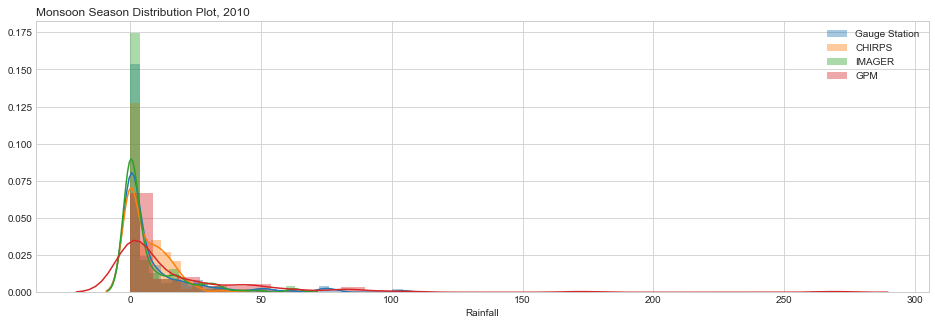

In [55]:
sns.distplot(monsoon_gauge['rainfall_rate'], hist=True, kde=True, label='Gauge Station')
sns.distplot(monsoon_chirps['precip'], hist=True, kde=True, label='CHIRPS')
sns.distplot(monsoon_prat['rainfall_rate'], hist=True, kde=True, label='IMAGER')
sns.distplot(monsoon_gpm['precipitationCal'], hist=True, kde=True, label='GPM')
plt.legend()
plt.title('Monsoon Season Distribution Plot, 2010', loc="left")
plt.xlabel("Rainfall");

### Basic data analysis for the IMAGER data

In [18]:
# daily_statistics_df = pd.DataFrame()
# monthly_statistics_df = pd.DataFrame()
# daily_statistics_df['daily_total_rate'] = rainfall_df.rainfall_rate.resample('D').sum()
# daily_statistics_df['daily_mean_rate'] = rainfall_df.rainfall_rate.resample('D').mean()
# monthly_statistics_df['monthly_total_rate'] = rainfall_df.rainfall_rate.resample('M').sum()
# monthly_statistics_df['monthly_mean_rate'] = rainfall_df.rainfall_rate.resample('M').mean()

In [19]:
# plt.plot(monthly_statistics_df['monthly_mean_rate'] )
# plt.title("Monthly Mean rainfall from IMAGER, 2010", loc='left')
# plt.xlabel('Timestamp')
# plt.ylabel('Mean Rainfall')
# ax = plt.gca()
# locator = mdates.MonthLocator()
# month_fmt = mdates.DateFormatter('%b')
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(month_fmt)

In [ ]:
# corr = monsoon_gauge['rainfall'].corr(monsoon_precip_df['precip'], method='pearson')
# corr

In [ ]:
# chirps_mean = precip_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

In [ ]:
# fig_to_pdf(figures)

In [ ]:
imager_jan.corrwith(gauge_jan, method='pearson')

In [ ]:
monsoon_imager.corrwith(monsoon_gauge, method='pearson')

In [ ]:
monsoon_gauge.corrwith(monsoon_chirps_df['precip'], method='pearson')

## Correlation Calculation
---

In [ ]:
print(f"Correlation of Base Station with Gauge station data {monsoon_imager.corrwith(monsoon_gauge, method='pearson').values}")
print(f"Correlation of Base Station with GPM dataset {monsoon_imager.corrwith(monsoon_gpm['precipitationCal'], method='pearson').values}")
print(f"Correlation of Base Station with CHIRPS {monsoon_imager.corrwith(monsoon_chirps_df['precip'], method='pearson').values}")      

In [ ]:
pd.merge(monsoon_imager, monsoon_gauge, on='timestamp').resample('1M')[['rainfall_rate_x', 'rainfall_rate_y']].corr().groupby(level=0).first()

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.scatter(monsoon_gauge['rainfall_rate'], monsoon_imager['rainfall_rate'], alpha=0.7)
plt.xlabel('Gauge Station')
plt.ylabel('Ground Based')
plt.subplot(1,3,2)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_imager['rainfall_rate'], alpha=0.7, c='r')
plt.xlabel('GPM')
plt.subplot(1,3,3)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_chirps_df['precip'], alpha=0.7, c='g')
plt.xlabel('CHIRPS');

## Dynamic Time Warping (DTW) -
---

In [ ]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
imager_scaled = scaler.fit_transform(monsoon_imager['rainfall_rate'])
gauge_scaled = scaler.fit_transform(monsoon_gauge['rainfall_rate'])
path_gauge, sim_gauge = metrics.dtw_path(monsoon_imager['rainfall_rate'], monsoon_gauge['rainfall_rate'])
path_gpm, sim_gpm = metrics.dtw_path(monsoon_imager['rainfall_rate'], monsoon_gpm['precipitationCal'])
print(f"DTW similarity score between ground based and gauge station is {sim_gauge}")
print(f"DTW similarity score between ground based and GPM is {sim_gpm}")

In [ ]:
imager_scaled[:, :, 0]